
# In short:
Skymap is a local database that offers: 
1. **a single data matrix** for each omic layer for each species that [spans >200k sequencing runs from all the public studies](https://www.ncbi.nlm.nih.gov/sra), which is done by reprocessing **peta**bytes worth of sequencing data. Here is how much published data are out there: 
![alt text](./Figures/sra_data_availability.png "Logo Title Text 1")

2. **a biological metadata file** that describe the relationships between the sequencing runs and also the keywords extracted from freetext annotations using NLP. 
3. **a techinical metadata file** that describe the relationships between the sequencing runs. 

#### The data is hosted in here: https://www.synapse.org/skymap (take < 3 minutes to set up the account). 

[In terms of validation of allelic alignment, we compared against TCGA pipeline as gold. standard](https://github.com/brianyiktaktsui/Skymap/blob/master/jupyter-notebooks/clean_notebooks/CompareTCGA_alignment_w_mine_pipe.ipynb)

Here are the slides for explaining the process and rationale of [allelic read counts extraction over 300k known SNPs](https://docs.google.com/presentation/d/1KcumgtLfCdHNnIwkbU5DaQ7UNKHGbJ_fJZFy1cj53yE/edit#slide=id.p3), [RNAseq quantification and NLP processing](https://docs.google.com/presentation/d/14vLJJQ6ziw-2aLDoQAJGyv1sYo5ENzljsqsbZr9jNLM/edit#slide=id.p19)  in a semi-scientific manner.

Here is an example of using simple coding to aggregate massive amount of data in a [self contained notebook](https://github.com/brianyiktaktsui/Skymap/blob/master/FindStudiesWithBrafV600Mutated.ipynb)
.
For convenience, I have sticked the notebook contents in below:

If you insteand to run it, first download the data from synapse

https://www.synapse.org/#!Synapse:syn11415602/wiki/492470

  
# Purpose of this notebook:  using skymap to slice out the sequencing runs associated with a BRAF V600 mutation and correlate it with expression (EQTL). 

Highlights:
* Take only seconds to slice all the allelic read counts for >100k worth of samples in a particular region.  
* Identify variant associations using NLP extracted labels from experimental annotations
* Take < 1 minute to slice out the relevant expression matrix and go from data to association. 
* identify experiemnts where mutation is shown in molecular data but not in the experimental annotation. 


##  <20 lines of code to slice out 100k experiments and their SNP near BRAF V600 in seconds

In [1]:
### parameters
import pandas as pd
import numpy as np
mySpecie='Homo_sapiens'
"""
Download from synapse if it is not installed
"""
skymap_snp_dir='/cellar/users/btsui/Data/SRA/snp/{specie}_snp_pos/'.format(specie=mySpecie)

In [2]:
!ls /cellar/users/btsui/Data/SRA/snp/Homo_sapiens_snp_pos/

Pos_block_0	     Pos_block_174200000  Pos_block_25400000
Pos_block_100000     Pos_block_174300000  Pos_block_25500000
Pos_block_1000000    Pos_block_174400000  Pos_block_25600000
Pos_block_10000000   Pos_block_174500000  Pos_block_25700000
Pos_block_100000000  Pos_block_174600000  Pos_block_25800000
Pos_block_100100000  Pos_block_174700000  Pos_block_25900000
Pos_block_100200000  Pos_block_174800000  Pos_block_2600000
Pos_block_100300000  Pos_block_174900000  Pos_block_26000000
Pos_block_100400000  Pos_block_17500000   Pos_block_26100000
Pos_block_100500000  Pos_block_175000000  Pos_block_26200000
Pos_block_100600000  Pos_block_175100000  Pos_block_26300000
Pos_block_100700000  Pos_block_175200000  Pos_block_26400000
Pos_block_100800000  Pos_block_175300000  Pos_block_26500000
Pos_block_100900000  Pos_block_175400000  Pos_block_26600000
Pos_block_10100000   Pos_block_175500000  Pos_block_26700000
Pos_block_101000000  Pos_block_175600000  Pos_block_26800000
Pos_block_101100000  Pos_bloc

### BRAF V600 coordinate 

In [3]:
#location where BRAF V600 happens, you can change it to whatever position you want 
#http://cancer.sanger.ac.uk/cosmic/mutation/overview?id=476
queryChr,queryPosition='7',140753336 

In [4]:
window=15
readThreshold=5

static code for slicing out the data

In [5]:
#str(myChunk)

In [6]:
%%time
chunkSize=100000 #fixed params
myChunk=int(queryPosition/chunkSize)*chunkSize
print (myChunk)
hdf_s=pd.HDFStore(skymap_snp_dir+'Pos_block_'+str(myChunk),mode='r')
tmpChunkDf=hdf_s['/chunk']
myPosDf=tmpChunkDf[(tmpChunkDf.Pos>=(queryPosition-window))&(tmpChunkDf.Pos<=(queryPosition+window))].reset_index()
m1=myPosDf[b'Chr']==queryChr
m2=myPosDf['ReadDepth']>=readThreshold
myChrPosDf=myPosDf[m1&m2]

140700000
CPU times: user 5.78 s, sys: 664 ms, total: 6.45 s
Wall time: 4.76 s


In [7]:
#myPosDf

In [8]:
print ('# of studies sliced out:' ,tmpChunkDf.Run_digits.nunique())

# of studies sliced out: 149064


### the slice out the window at around BRAF V600

In [9]:
myChrPosDf.head()

b'features',b'Chr',b'base',b'Run_db',Run_digits,Pos,ReadDepth,AverageBaseQuality,block
2,7,C,SRR,1177675,140753321,9,39,140700000
3,7,C,SRR,4444531,140753321,5,40,140700000
6,7,C,SRR,5882370,140753321,39,39,140700000
9,7,C,SRR,5111728,140753321,5,39,140700000
17,7,C,SRR,2125816,140753321,5,37,140700000


#### meaning of each column
Chr: Chromosome

Base: DNA bases in aligned reads - A, C, G, T 

Run_db and Run_digits together forms a SRR accession id. I ignored the leading 0s for Run_digits. 

ReadDepth: the number of bases detected in aligned reads at a particular base and chromosome position. 

AverageBaseQuality: The mean phred score in aligned reads at a particular base and chromosome postiion. 

Pos: Chromosome position. (grch38 for human)

block: the block ID used for chunked storage

# The above 20 lines are basically all you need to know
to identify hundred thousands of sequencing runs with reads near your query postion. 

Keep reading if you are interested in some examples of basic analysis. 


###### find reference base for each chrosome coordinate

In [10]:
###it's a 
"""
The original vcf file can be downloaded from: ftp://ftp.ncbi.nih.gov/snp/organisms/human_9606/VCF/All_20170710.vcf.gz
I ignored all the entries without any phentoype related resources to suppport, where the byte2 of the VCF equals to zero.
For more info: ftp://ftp.ncbi.nlm.nih.gov/snp/specs/dbSNP_BitField_latest.pdf
"""
inVcfDir='/data/cellardata/users/btsui/dbsnp/Homo_sapiens/All_20170710.f1_byte2_not_00.vcf.gz' 
vcfDf=pd.read_csv(inVcfDir,sep='\t',header=None)
vcfDf.columns=['Chr','Pos','RsId','RefBase','AltBase','','','Annot']
vcfDf['Chr']=vcfDf['Chr'].astype(np.str)
my_chrom_vcfDf=vcfDf[(vcfDf['Chr']==queryChr)]
posToRefBase=my_chrom_vcfDf.set_index('Pos')['RefBase']
posToRefBase=posToRefBase.str[0]
posToRefBase=posToRefBase.groupby(posToRefBase.index).first()


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### visualize the landscape of BRAFV600 mutated samples

Since human sequencing data are mostly generated from cell lines, we expect the cells measured often come with a highly  specifc oncogeneic transformation, thus we should observe a overpresenation of data with BRAFV600 as compared to its immediate neighboring regions, as shown in the following figure.

In [11]:
myChrPosDf.head()

b'features',b'Chr',b'base',b'Run_db',Run_digits,Pos,ReadDepth,AverageBaseQuality,block
2,7,C,SRR,1177675,140753321,9,39,140700000
3,7,C,SRR,4444531,140753321,5,40,140700000
6,7,C,SRR,5882370,140753321,39,39,140700000
9,7,C,SRR,5111728,140753321,5,39,140700000
17,7,C,SRR,2125816,140753321,5,37,140700000


In [12]:

### recover reference base
myChrPosDf['RefBase']=posToRefBase.loc[myChrPosDf['Pos']].values
### is base alt?
myChrPosDf['AltBase']=myChrPosDf['RefBase']!=myChrPosDf[b'base']
#### consider dropping duplciates of Runs (a runs can have multiple bases) 
myPosCountDf=myChrPosDf.groupby(['Pos','AltBase']).size()

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [13]:
inDf=myPosCountDf.unstack()
fractionDf=(inDf.T/inDf.sum(axis=1)).T

[]

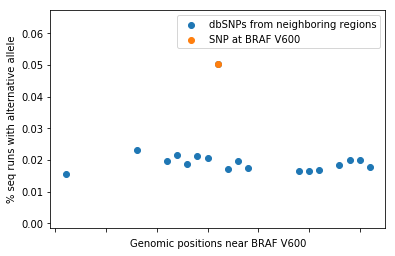

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax=plt.subplots()
ax.scatter(x=fractionDf.index,y=fractionDf[True],label='dbSNPs from neighboring regions')
queryDf=fractionDf[fractionDf.index==queryPosition]
ax.scatter(x=[queryPosition],y=fractionDf.loc[[queryPosition]][True],label='SNP at BRAF V600')
ax.set_ylabel('% seq runs with alternative allele')
ax.set_xlabel('Genomic positions near BRAF V600')
ax.legend()
ax.set_xticklabels([])

### BRAF V600 mutation are measured and extracted from many different data layers

as show in the following figure

In [15]:
altBaseDf=myChrPosDf[(myChrPosDf['Pos']==queryPosition)&(myChrPosDf['AltBase'])]

In [16]:
altBaseDf.head()

b'features',b'Chr',b'base',b'Run_db',Run_digits,Pos,ReadDepth,AverageBaseQuality,block,RefBase,AltBase
2032,7,T,SRR,3631114,140753336,44,36,140700000,A,True
2046,7,G,SRR,2961201,140753336,9,23,140700000,A,True
2047,7,C,SRR,2961201,140753336,5,16,140700000,A,True
3854,7,C,SRR,1060438,140753336,6,13,140700000,A,True
8067,7,C,SRR,1060416,140753336,8,7,140700000,A,True


In [17]:
altBaseDf=altBaseDf.set_index([b'Run_db','Run_digits'])

### load in technical meta data

For more information about the aliases used in the follow meta data:

https://www.ncbi.nlm.nih.gov/books/NBK56913/



In [18]:
sra_dump_pickle_dir='/cellar/users/btsui/Data/SRA/DUMP/sra_dump.pickle'

technical_meta_data_df=pd.read_pickle(sra_dump_pickle_dir)

In [19]:
technical_meta_data_df.shape

(3763299, 23)

#### use the techinical meta data table to backtrack which omic layers the study is from

In [20]:
technical_meta_data_df.head()

,Member_Name,Experiment,Sample,Study,Spots,Bases,Status,ScientificName,LibraryStrategy,LibraryLayout,...,proj_accession_Published,proj_accession_Received,proj_accession_Type,proj_accession_Center,proj_accession_Visibility,proj_accession_Loaded,proj_accession_ReplacedBy,new_ScientificName,Run_db,Run_digits
Run,,,,,,,,,,,,,,,,,,,,,
SRR2401865,default,SRX1244330,SRS1068422,-,2800.0,1416405.0,live,soil_metagenome,AMPLICON,SINGLE,...,2015-09-20,2015-09-15,RUN,SUB1095135,public,1,-,soil_metagenome,SRR,2401865
SRR2401866,default,SRX1244331,SRS1068421,-,5082.0,2563605.0,live,soil_metagenome,AMPLICON,SINGLE,...,2015-09-20,2015-09-15,RUN,SUB1095135,public,1,-,soil_metagenome,SRR,2401866
SRR2401867,default,SRX1244332,SRS1068420,-,6169.0,3175528.0,live,soil_metagenome,AMPLICON,SINGLE,...,2015-09-20,2015-09-15,RUN,SUB1095135,public,1,-,soil_metagenome,SRR,2401867
SRR2401868,default,SRX1244333,SRS1068419,-,8102.0,4266915.0,live,soil_metagenome,AMPLICON,SINGLE,...,2015-09-20,2015-09-15,RUN,SUB1095135,public,1,-,soil_metagenome,SRR,2401868
SRR2401869,default,SRX1244334,SRS1068418,-,4971.0,2519200.0,live,soil_metagenome,AMPLICON,SINGLE,...,2015-09-20,2015-09-15,RUN,SUB1095135,public,1,-,soil_metagenome,SRR,2401869


In [21]:
technical_meta_data_df['Run']=technical_meta_data_df.index

In [22]:
technical_meta_data_df=technical_meta_data_df.set_index(['Run_db','Run_digits'])#.index.isin(altBaseDf.index)

In [23]:
hitSrrDf=technical_meta_data_df[technical_meta_data_df.index.isin(altBaseDf.index)]

Text(0,0.5,'# of sequencing runs')

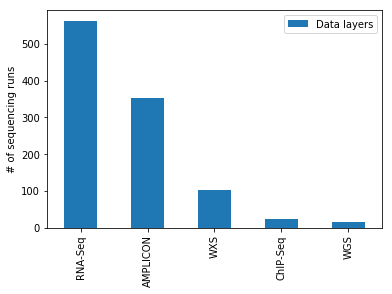

In [24]:
VC=hitSrrDf.LibraryStrategy.value_counts()
ax=VC[VC>0].to_frame('Data layers').plot.bar()
ax.set_ylabel('# of sequencing runs')

# compare with CDK4 and CDK6 expression

* Given that: BRAFV600 mutation is associated proliferation. 
* We should observe stronger proliferation signal: And in this example we use CDK4 and CDK6 expression level as read out for proliferaiton: 
http://cancerdiscovery.aacrjournals.org/content/6/4/353

### memory map the expression data matrix

In [25]:

def loadDf(fname,mmap_mode='r'):
    with open(fname+'.index.txt') as f:
        myIndex=map(lambda s:s.replace("\n",""), f.readlines())
    with open(fname+'.columns.txt') as f:
        myColumns=map(lambda s:s.replace("\n",""), f.readlines())
    tmpMatrix=np.load(fname+".npy",mmap_mode=mmap_mode)
    tmpDf=pd.DataFrame(tmpMatrix,index=myIndex,columns=myColumns)
    tmpDf.columns.name='Run'
    return tmpDf

In [26]:
expression_metric='TPM'
#change this to where the matrix is located on your computer
baseDir='/cellar/users/btsui/Data/nrnb01_nobackup/Data/SRA/MATRIX/DATA/hgGRC38/'
data_matrix_dir_fmt=baseDir+'/allSRAmatrix.realign.v9.base.{feature}.gene.symbol'.format(feature=expression_metric)
rnaseqDf=loadDf(data_matrix_dir_fmt)

### dimension of expression dataframe 

In [27]:
rnaseqDf.shape

(27233, 126064)

### head of expression dataframe

In [28]:
rnaseqDf.head()

Run,SRR4456480,SRR4456481,SRR4456482,SRR4456483,SRR4456484,SRR4456485,SRR4456486,SRR4456487,SRR4456488,SRR4456489,...,SRR3126580,SRR3126581,SRR5076964,SRR5076965,SRR5076966,SRR5076967,SRR5076960,SRR5076961,SRR5076962,SRR3126589
A1BG,0.000000,0.00000,0.00000,0.0,0.0,43.4725,42.39500,0.0,0.0000,0.0000,...,13.633400,16.613701,30.397053,38.792152,28.311970,41.916702,21.123585,43.892700,27.982466,10.015800
A1CF,0.000000,0.00000,0.00000,0.0,0.0,0.0000,0.00000,0.0,0.0000,0.0000,...,1.008490,0.731485,0.522371,0.619676,1.073180,1.200200,1.149905,0.359585,2.151589,0.000000
A2M,0.000000,9.68203,9.63777,0.0,0.0,0.0000,0.00000,0.0,10.2231,15.0466,...,0.000000,1.022370,2.237999,1.686480,1.736842,2.459877,2.030084,2.870860,1.394481,0.147562
A2ML1,90.239403,0.00000,0.00000,0.0,0.0,0.0000,4.50392,0.0,0.0000,0.0000,...,0.383746,0.222499,0.738123,1.604510,1.749147,1.575887,0.630090,0.466597,0.836070,0.000000
A2MP1,0.000000,0.00000,0.00000,0.0,0.0,0.0000,0.00000,0.0,0.0000,0.0000,...,0.000000,0.000000,0.000000,1.862630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [29]:
%%time 
A=rnaseqDf.loc[:,rnaseqDf.columns.isin(hitSrrDf['Run'].values)]

CPU times: user 92 ms, sys: 584 ms, total: 676 ms
Wall time: 16.9 s


#### randomly sample a background

In [30]:
n=A.shape[1]
backgroundSrrs=rnaseqDf.columns.to_series().sample(n=n).values
B=rnaseqDf.loc[:,backgroundSrrs]

#### query the CDK4 and CDK6 expression levels 

In [31]:
inGenes=['CDK4','CDK6']

In [32]:
caseLabel='With BRAF V600 mutation\n n='+str(n)
ctrlLabel='CTRL\n n='+str(n)
exprDf=np.log2(pd.concat([ A.loc[inGenes],B.loc[inGenes]],axis=1,keys=[caseLabel,ctrlLabel],names=['Status'])+1)
exprDf.index.name='Gene'

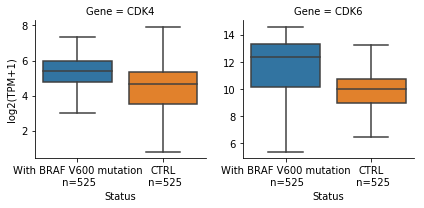

In [33]:
from scipy import stats
import seaborn as sns
yLabel='log2(TPM+1)'
inDf=exprDf.T.stack().reset_index(name=yLabel)
inPlotDf=inDf[inDf[yLabel]>0.5]### an arbitrary threshold to throw away the tail at 0
sns.factorplot(data=inPlotDf,col='Gene',x='Status',y=yLabel,showfliers=False,kind='box',sharey=False,size=3)


yay, p-values are less than 0.05 (if you follow the p-values cult)

In [34]:
for inGene in inGenes:
    tmpDf=inPlotDf[inPlotDf['Gene']==inGene]
    tmp_A=tmpDf[tmpDf['Status']==caseLabel][yLabel]
    tmp_B=tmpDf[tmpDf['Status']==ctrlLabel][yLabel]
    t,p=stats.ttest_ind(tmp_A,tmp_B)
    print (inGene,p)

CDK4 2.2212820518863575e-09
CDK6 3.5036915244467543e-34


### What are the labels extracted from annotations of sequencing runs with BRAF V600 mutations


### load in biological meta data

For more information about bio_metaDf columns:

Sample: https://www.ncbi.nlm.nih.gov/books/NBK56913/

attribute: https://www.ncbi.nlm.nih.gov/biosample/docs/attributes/

NCIT_Eng, NCIT_ID: https://ncit.nci.nih.gov/

NLM_CUI: https://www.nlm.nih.gov/research/umls/new_users/online_learning/Meta_005.html

The NLP tool used for mapping freetexts to terms is called metamap:
https://metamap.nlm.nih.gov/

In [35]:
metaDataMappingSDir='/cellar/users/btsui/Data/nrnb01_nobackup/METAMAP//input/allAttrib.v5.csv.NCI.prefilter.pyc'
bio_metaDf=pd.read_pickle(metaDataMappingSDir)

Millions of biological annotations have NLP key words extracted with high number of unique terms, suggesting that public data deposited in SRA has both high volumne and diversity in experimental conditions. 

In [36]:
print '# of unique biological sample annotations with terms extracted:',bio_metaDf['srs'].nunique()

SyntaxError: invalid syntax (<ipython-input-36-eeb53e159da6>, line 1)

In [ ]:
print '# of unique biomedical terms:',bio_metaDf['NCI'].nunique()

#### slice out the biological meta data associated with BRAF V600 mutations

In [ ]:
hitMetaDf=bio_metaDf[bio_metaDf.srs.isin(hitSrrDf['Sample'].unique())]

### the attributes associated with the meta data

picking the restricted attributes you key to slice on usually improve relevancy of labels

In [ ]:
hitMetaDf['attrib'].value_counts().head(n=10)

### most commmon terms from annotations of sequencing runs with BRAF V600 mutations

It is unsurprising that "Melnaoma" is in one of the top terms. 

In [ ]:
selected_attribs=['source name','TITLE','tissue','phenotype']
ax=hitMetaDf[hitMetaDf['attrib'].isin(selected_attribs)]['NciEng'].value_counts().head(n=30).plot.bar()#.drop_duplicates()
ax.set_ylabel('# of sequencing runs')

### use ontology to identify relevant terms

take only tissue and disease relevant terms by taking the children terms of the term "Tissue"

In [ ]:
import NCITerminology as NCIT

In [ ]:
onto=NCIT.NCITerminology()

In [ ]:
### subset the edges to traverse only part_of, is_a and disease edges
is_a_rels=onto.relToEng[onto.relToEng.str.lower().str.contains('(?:has[\w_]+_parent)|(?:disease)')].index.tolist()+['is_a','R82']
onto.setCellOntoEdgeSubset(is_a_rels)

In [ ]:
onto.cleanedIdS[onto.cleanedIdS.str.contains('^Tissue$')]

In [ ]:
childrenTerms=(onto.childrenTermsOf('C12801'))

In [ ]:
ax=hitMetaDf[hitMetaDf['attrib'].isin(selected_attribs)&hitMetaDf['NCI'].isin(childrenTerms)]['NciEng'].value_counts().head(n=30).plot.bar()#.drop_duplicates()
ax.set_ylabel('# of sequencing runs')

### What are the experiments with BRAF V600 mutation that are extracted from Bone?

In [ ]:
myHitTechnicalDf=technical_meta_data_df[technical_meta_data_df['Sample'].isin(hitMetaDf[(hitMetaDf['NciEng']=='Bone')]['srs'].values)]

### the top experiment is from this study

In [ ]:
myHitTechnicalDf['Study'].value_counts().head(n=2)

It is rather unexpected that the term "Bone" is the most freqeunt term. 
And when I reference SRA db: 
https://www.ncbi.nlm.nih.gov/sra/?term=SRP067759
It is showing this single cell leukemia RNAseq study study: https://www.nature.com/articles/nm.4336
, where luekemia begins in bone marrow.

The BRAF V600 mutation is not mentioned in their study,
but there are multiple evidence to support the confidence of this mutation:

1. Many of their allelic read counts usually have the A->T mutation, which is the more common transition for oncogenic transformation.
2. High read depth for alternative allele (T) across across many experiments.
3. High base quality for the alternative allele (T)



In [ ]:
queryPosDf=myChrPosDf[(myChrPosDf['Pos']==queryPosition)].set_index(['Run_db','Run_digits'])

In [ ]:
queryPosDf['log10_ReadDepth']=np.log10(queryPosDf['ReadDepth'])

In [ ]:
subHitDf=queryPosDf.loc[queryPosDf.index.isin(myHitTechnicalDf.index)]

a lot of the RNAseq samples have alternative allele, T, detected

In [ ]:
ax=subHitDf.groupby(['base']).size().sort_values(ascending=False).plot.bar()
ax.set_ylabel('# of sequencing runs with more than 5 reads at base')

the alternative allele T has high read depth over all the leukemia RNAseq samples

In [ ]:
sns.boxplot(data=queryPosDf.loc[queryPosDf.index.isin(myHitTechnicalDf.index)].dropna(),x='base',y='log10_ReadDepth')

the alternative allele T often have high base quality over all the leukemia RNAseq samples

In [ ]:
sns.boxplot(data=queryPosDf.loc[queryPosDf.index.isin(myHitTechnicalDf.index)].dropna(),x='base',y='AverageBaseQuality')

### tally them mory usage 

For performance reason, we try to keep as much data in memory as possible. 
Metadata is small, genomic data is big. 
Metadata is stored in a single pickle.

Molecular data can't be loaded in memory therefore, we keep the molecular data on disk and load them in when needed.
1. SNP data is stored in chunks of HDF5 object. We ignored the last 5 digits in the genomic position and use the prefix as the chunk name. 
2. Expression data is stored as a single numpy matrix, which offer memory mapping 

In [ ]:
print 'memory used by technical meta dataframe(GB):',float(technical_meta_data_df.memory_usage().sum())/10**9

In [ ]:
print 'memory used by biological meta dataframe(GB):',float(bio_metaDf.memory_usage().sum())/10**9

### size of disk usage

1. snp data takes roughly 200G of the disk space once decompressed
2. expression matrix takes roughly 20G


In [ ]:
!ls -laht /cellar/users/btsui/Data/SRA/snp/Homo_sapiens_snp_pos/  | head -n 1

In [ ]:
!ls -lah /cellar/users/btsui/Data/nrnb01_nobackup/Data/SRA/MATRIX/DATA/hgGRC38/allSRAmatrix.realign.v9.base.TPM.gene.symbol.npy

# more examples

#### High resolution mouse developmental hierachy map
[Link](https://github.com/brianyiktaktsui/Skymap/blob/master/jupyter-notebooks/clean_notebooks/TemporalQuery_V4_all_clean.ipynb
)

Aggregating many studies (node) to form a smooth mouse developmental hierachy map. 

Each componenet represent a tissue. Each node represent a particular study at a particular time unit. The color is base on the developmental time extracted from experimental annotation using regex. The node size represent the # of sequencing runs in that particulr time point and study. Each edge represent a differentiate-to or part-of relationship.
![alt text](./Figures/heirachy_time.png "Logo Title Text 1")
And you can easily overlay gene expression level on top of it. As an example, Tp53 expression is known to be tightly regulated in development. Let's look at the dynamic of Tp53 expression over time and spatial locations in the following plot.
![alt_text](./Figures/heirachy_Trp53.png "tp53")

#### simple data slicing and hypothesis testing
[Link](https://github.com/brianyiktaktsui/Skymap/blob/master/DataSlicingExample.ipynb)

[Check here for more example notebooks](https://github.com/brianyiktaktsui/Skymap/tree/master/jupyter-notebooks
)

The code for the pipelines is here:
https://github.com/brianyiktaktsui/Skymap/tree/master/code


# In long: 
## Motivation: Pooling processed data from multiple studies is time-consuming: 
When I first started in bioinformatic couple years ago, I spent much of my time doing two things: 1.) cleaning omic data matrices, e.g. mapping between gene IDs (hgnc, enseml, ucsc, etc.) for processed data matrices, trying all sort of different bioinformatics pipelines that yield basically the same results, investigating what is the exact unit being counted over when pulling data from public database, etc.  2.) cleaning metadata annotation, which usually involves extracting and aliasing the labels to the exact same categories. 

This question came to my mind: Can we merge and reduce the peta-bytes worth of public omic data in a table while capturing the commonly used information that can fit into your hard drive (<500 GB), like firehose for TCGA data? 

## Solution: An automated pipeline to generate a single data matrix that does simple counting for each specie and omic layer 
What I am offering in here is a metadata table and a single data matrix for each omic layer that encapsulate majority of the public data out there. I do believe that “Science started with counting” (from “Cancer: Emperor of all malady” by Siddhartha Mukherjee), and thus I offer raw counts for all the features: 1. ) the  base resolution ACGT counts for over 200k experiments among NCBI curated SNPs, where read depth and allelic fraction are usually the main drivers for SNP calling. We also offer an expression matrix, where most counts at both transcript and gene resolution, where most normalization can be done post-hoc. 
The metadata table consists of controlled vocabulary (NCI Terminology) from free text annotations of each experiment. I used the NLM metamap engine for this purpose. The nice thing is that the UMLS ecosystem from NLM allow the IDs (Concept Unique Identifiers) to be mapped onto different ontology hierarchy to relate the terms. 
The pipeline in here is trying to suit the needs of the common use cases. In another word, most pipelines out there are more like sport cars, having custom flavors for a specific group of drivers. What I am trying to create is more like a train system, aiming to suit most needs. Unfortunately, if you have more specific requirements, what I am offering is probably not going to work. 

## Why Skymap while there are so many groups out there also trying to unify the public data
To the best of my knowledge, Skymap is the first that offer both the unified omic data and cleaned metadata. The other important aspect is that the process of data extraction is fully automated, so it is supposed to be scalable.  
Data format and coding style:
I tried to keep the code and parameters to be lean and self-explanatory for your reference, but most of the scripts I wrote are far from the industrial standard. 
The storage is in python pandas pickle format. The ecosystem in python appears to be much better at handling large dataset while offering intuitive coding interfaces. For now, Skymap is geared towards ML/data science folks who are hungry for the vast amount of data and ain’t afraid of coding.

Skymap is still in Beta V0.0. [Please feel free to leave comments](https://www.synapse.org/#!Synapse:syn11415602/discussion/default) and suggestions!!! We would love to hear feedbacks from you.
## Acknowledgement


Please considering citing if you are using Skymap. (doi:10.7303/syn11415602)

Acknowledgement: We want to thank for the advice and resources from Dr. Hannah Carter (my PI), Dr. Jill Mesirov,Dr. Trey Ideker and Shamin Mollah. We also want to thank Dr. Ruben Arbagayen, Dr. Nate Lewis for their suggestion. 
The method will soon be posted in bioarchive. Also, we want to thank the Sage Bio Network for hosting the data. We also thank to thank the NCBI for holding all the published raw reads at  [Sequnece Read Archive](https://www.ncbi.nlm.nih.gov/sra). 
Grant money that make this work possible: NIH DP5OD017937,GM103504

Term of use: Use Skymap however you want. Just dont sue me, I have no money. 

For why I named it Skymap, I forgot.

In [ ]:
VC=bio_metaDf.NciEng.value_counts()

In [ ]:
VC[VC.index.str.contains('Asthma',case=False)]

In [ ]:
#bio_metaDf.head()

In [ ]:
technical_meta_data_df.shape

In [ ]:
public_meta_df=technical_meta_data_df[(technical_meta_data_df['proj_accession_Visibility']=='public')]

In [ ]:
#public_meta_df

In [ ]:
bio_metaDf[(bio_metaDf.NciEng=="Asthma")&(bio_metaDf.srs.isin(public_meta_df.Sample))]